# **DATA ANALYSIS - PH Twitter Mis/Disinformation on Redtagging**<hr>

In [75]:
# Import the necessary libraries
from typing import ItemsView
import matplotlib.pyplot as plt
import pandas as pd

import tweepy, sys, re
import sched, time, datetime
import csv, openpyxl, xlsxwriter
import pprint

import numpy as np
import string, re
import itertools
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
import keras
# import ipynb.fs.defs.preprocessing as prep
py.init_notebook_mode(connected=True)
%matplotlib inline


## Preprocessing<hr>

Read the data

In [76]:
# Open the dataset workbook
workbook = openpyxl.load_workbook(filename = 'Text Value only Dataset - Group 32.xlsx')
worksheet = workbook['Value only']
worksheet.max_column

# Convert to a Pandas dataframe
data = worksheet.values
df = pd.DataFrame(data, columns=next(data)[0:])
df.columns

Index(['ID', 'Timestamp', 'Tweet URL', 'Group', 'Collector', 'Category',
       'Topic', 'Keywords', 'Account handle', 'Account name', 'Account bio',
       'Account type', 'Joined', 'Following', 'Followers', 'Location', 'Tweet',
       'Tweet Translated', 'Tweet Type', 'Date posted', 'Screenshot',
       'Content type', 'Replies', 'Retweets', 'Quote Tweets', 'Views',
       'Rating', 'Reasoning', 'Remarks', 'Reviewer', 'Review'],
      dtype='object')

## Data Details

Review Data Samples

In [77]:
df.head(5)

,ID,Timestamp,Tweet URL,Group,Collector,Category,Topic,Keywords,Account handle,Account name,...,Content type,Replies,Retweets,Quote Tweets,Views,Rating,Reasoning,Remarks,Reviewer,Review
0,"=Text(D2,""00"")&""-""&ROW(D2)-1",21/02/23 16:19:00,https://twitter.com/amylauderdake/status/13303...,32.0,"Aloveros, Aira Mae",REDT,Red tagging students from different universities,UP NPA PUP,@amylauderdake,amylauderdake,...,Rational,0.0,0.0,0.0,None,UNPROVEN,Accuses that the said universities are NPA bre...,Location and bio are not specified,None,None
1,"=Text(D3,""00"")&""-""&ROW(D3)-1",21/02/23 16:20:10,https://twitter.com/SamukaNimoUy/status/152575...,32.0,"Aloveros, Aira Mae",REDT,Red tagging students from UP and PUP,UP NPA PUP,@SamukaNimoUy,-Nessa-,...,Rational,0.0,0.0,0.0,None,UNPROVEN,Accuses that the said universities are NPA bre...,Location is not specified,None,None
2,"=Text(D4,""00"")&""-""&ROW(D4)-1",21/02/23 16:25:35,https://twitter.com/Shaider_de/status/13519219...,32.0,"Delos Reyes, Rey",REDT,Red tagging students from UP and PUP,UP NPA PUP,@Shaider_de,Dai Sawamura,...,Rational,0.0,0.0,0.0,None,UNPROVEN,Accuses that leaders of NPA comes from PUP and...,None,None,None
3,"=Text(D5,""00"")&""-""&ROW(D5)-1",21/02/23 17:23:35,https://twitter.com/n4qpu/status/1351844058935...,32.0,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,TERORISTA UP NPA,@n4qpu,浜崎 夏海 🏅,...,Emotional,0.0,0.0,0.0,None,MISLEADING,Suggests that student activists will recruit t...,None,None,None
4,"=Text(D6,""00"")&""-""&ROW(D6)-1",21/02/23 17:25:35,https://twitter.com/JethroGamez/status/1293145...,32.0,"Doros, Joshua Lloyd",REDT,Red tagging students from UP,TERORISTA UP NPA,@JethroGamez,jethjeth ♥️💚,...,Emotional,0.0,0.0,0.0,None,UNPROVEN,Accuses UP of being controlled by the CPP-NPA-...,None,None,None


Size of Dataset 

In [78]:
df.shape

(168, 31)

The dataset has 168 tweets and 30 features.

The variable that has most null values is Account Bio, Screenshot, and Views. The columns that has null values are dropped to create `df_clean`

In [79]:
df.isnull().sum()

ID                    0
Timestamp             0
Tweet URL             0
Group                 0
Collector             0
Category              0
Topic                 0
Keywords              0
Account handle        0
Account name          0
Account bio          41
Account type          0
Joined                0
Following             0
Followers             0
Location             90
Tweet                 0
Tweet Translated      0
Tweet Type            0
Date posted           0
Screenshot          168
Content type          0
Replies               0
Retweets              0
Quote Tweets          6
Views               168
Rating                1
Reasoning             0
Remarks              68
Reviewer            168
Review              168
dtype: int64

In [80]:
df_clean = df.dropna(axis=1)
(df.shape, df_clean.shape)
df_clean.columns

Index(['ID', 'Timestamp', 'Tweet URL', 'Group', 'Collector', 'Category',
       'Topic', 'Keywords', 'Account handle', 'Account name', 'Account type',
       'Joined', 'Following', 'Followers', 'Tweet', 'Tweet Translated',
       'Tweet Type', 'Date posted', 'Content type', 'Replies', 'Retweets',
       'Reasoning'],
      dtype='object')

The  features retained and their corresponding meaning is as follows

|Feature|Meaning|
|-|-|
|ID||
|Timestamp||
|Tweet URL||
|Group||
|Collector||
|Category||
|Topic||
|Keywords||
|Account handle||
|Account name||
|Account type||
|Joined ||
|Following||
|Followers||
|Tweet||
|Tweet Translated||
|Tweet Type||
|Data posted||
|Content type||
|Replies||
|Retweets||
|Reasong||in

Convert the column to datetime

### Tweets

In [81]:
df_Tweets = df_clean['Tweet']
df_Tweets

0      Typical NPA UNIVERSITIES   .... Ateneo, UP. PU...
1                 UP and PUP are NPA’s recruitment hubs.
2      History itself shows that Almost all CPP/NPA L...
3      Tapos ire-recruit nila yung makikita nilang po...
4      Well, I thought I'm gonna be brainwashed by th...
                             ...                        
163    @ilda_talk I vote for gov't agencies like DepE...
164    @AlfredoGenom @Maria398212 NPA recruit yan mga...
165    @andie0312 I don’t care if professors teach id...
166    @andie0312 Well, it’s happening in universitie...
167    @andie0312 My point is that she didn’t answer ...
Name: Tweet, Length: 168, dtype: object

The 168 tweets collected are all unique

In [82]:
df_Tweets.describe()

count                                                   168
unique                                                  168
top       Typical NPA UNIVERSITIES   .... Ateneo, UP. PU...
freq                                                      1
Name: Tweet, dtype: object

The length of each tweets in the dataset is as follows

In [83]:
df_Tweets.str.len()

0      105
1       38
2      156
3      169
4      208
      ... 
163    249
164    211
165    267
166    175
167    289
Name: Tweet, Length: 168, dtype: int64

In [84]:
df_Tweets.str.len().sum()

33999

In [85]:
tweet_len_ave = df_Tweets.str.len().sum()/df_Tweets.size
tweet_len_ave

202.375

### Dates

In [86]:
df_clean["Date posted"] = pd.to_datetime(df_clean["Date posted"])
df_clean["Date posted"]

C:\Users\REYCHR~1\AppData\Local\Temp/ipykernel_8932/2215845903.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0     2020-11-22 11:56:00
1     2022-05-15 16:37:00
2     2021-01-20 23:58:00
3     2021-01-20 18:48:00
4     2020-08-11 19:20:00
              ...        
163   2022-07-19 14:45:33
164   2022-09-19 00:36:46
165   2022-08-16 17:02:07
166   2022-08-07 09:07:47
167   2022-08-07 08:56:00
Name: Date posted, Length: 168, dtype: datetime64[ns]

In [87]:
df_count_per_year = pd.to_datetime(df_clean['Date posted']).dt.year.value_counts()

df_count_per_year

2021    66
2022    53
2020    28
2019    14
2018     4
2017     2
2016     1
Name: Date posted, dtype: int64

# Visualization<hr>

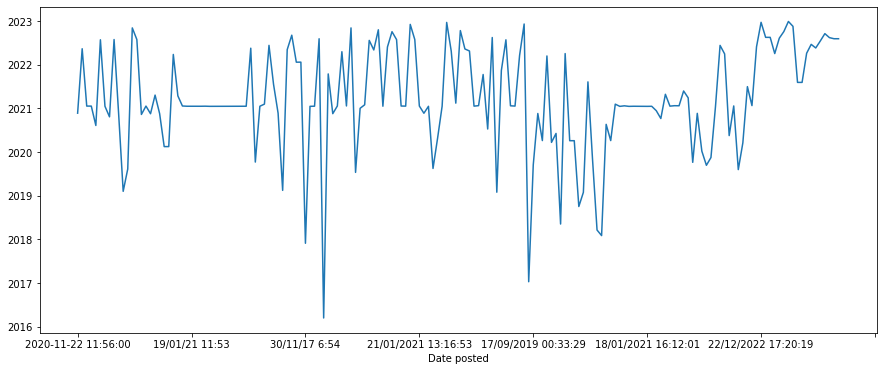

In [88]:
df_clean.index = df["Date posted"]
del df["Date posted"]
df_clean["Date posted"].plot(figsize=(15, 6))
plt.show()

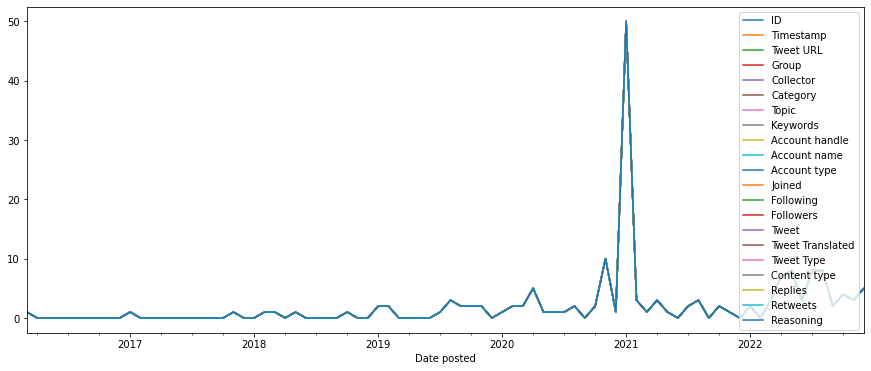

In [89]:
df_time = df_clean.groupby(pd.Grouper(key="Date posted", freq="1M")).count()
df_time.plot(figsize=(15, 6))
plt.show()

### Tweet Data

In [90]:
lens = df_clean['Tweet'].str.len()
(lens.mean(), lens.std(), lens.min(), lens.max())

(202.375, 77.12760151960947, 23, 335)

Distribution of tweet length:

In [91]:
data = [go.Histogram(x=lens, xbins=dict(start=0, end=8000, size=10), marker=dict(color='#8c42f4'))]
layout = go.Layout(
                  title='Length of tweets and post distribution',                  
                  xaxis=dict(title='Length'),
                  yaxis=dict(title='Count'),
                  bargap=0.1)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='length histogram')

In [94]:
df['Text_Length'] = df['Tweet'].apply(lambda x: len(x))
data = df.sort_values(by='Text_Length')
plot = go.Scatter(x = data['Text_Length'], y = data['Tag'], mode='markers')
lyt = go.Layout(title="Length vs. Sentiment Label", xaxis=dict(title='Tweet Length'),yaxis=dict(title='Label'))
fig = go.Figure(data=[plot], layout=lyt)
py.iplot(fig)

KeyError: 'Tag'